In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import fb_utils as fb

In [2]:
# set parameters

# signal length
N = 1024
# filter lengths
T_vals = 2**np.arange(3,11)
# number of filters
J = 10
# quantile
p = 0.05

In [3]:
# artificial signals

# impulse
x_impulse = np.zeros(N)
x_impulse[513] = 1
x_impulse = x_impulse/np.linalg.norm(x_impulse)

# brownian noise
x_rand = fb.brownian_noise(N,0.15)
x_rand = x_rand/np.linalg.norm(x_rand)

# sine
x_sine = (-np.ones(N)**np.arange(N))/np.sqrt(N)
x_sine = x_sine/np.linalg.norm(x_sine)

xs = [x_impulse, x_rand, x_sine] 

In [4]:
plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})
plt.rcParams["font.family"] = "Times New Roman"

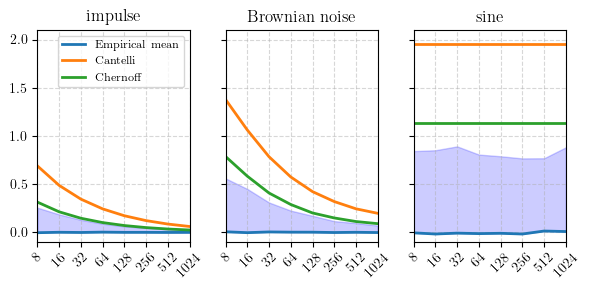

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(6, 3), sharey=True)
titles = ['impulse', 'Brownian noise', 'sine']
yticks = range(-2, 4)

for x_id, x in enumerate(xs):

    Ts = np.arange(0, len(T_vals))

    # filterbank energy stats

    Y = fb.random_filterbank_experiment(x, J, N, T_vals)
    Y_mean = np.mean(Y-1, axis=1)
    Y_quan = np.quantile(Y-1, 1-p, axis=1)

    Y_std = np.std(Y-1, axis = 1)
    Y_ci = (1+p) * Y_std

    Y_low = Y_mean - Y_ci
    Y_high = Y_mean + Y_ci
    
    # theoretical bounds

    #cheb = alpha_cheb(x, J, T_vals, p)
    cheb = fb.alpha_can(x, J, T_vals, p)

    cher = np.zeros(len(T_vals))
    for i,T in enumerate(T_vals):
        T = [T]
        out = fb.alpha_cher(x,J,T)
        cher[i] = out

    ax = axes[x_id]
    ax.plot(Y_mean, 'tab:blue', linewidth=2, label='Empirical mean')
    ax.fill_between(Ts, Y_mean, Y_quan, color='b', alpha=.2)

    ax.plot(cheb, 'tab:orange', linewidth=2, label='Cantelli')
    ax.plot(cher, 'tab:green', linewidth=2, label='Chernoff')

    ax.set_title(titles[x_id])
    ax.set_xticks(Ts, T_vals, rotation=45);
    #ax.set_xlabel('Filter length $T$')
    if x_id == 0:
        ax.legend(loc='upper right',fontsize = "small")

    ax.set_xlim(min(Ts), max(Ts))
    ax.set_ylim(-0.1, 2.1)
    ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('plots/energy_deviation_bounds_1.pdf', bbox_inches='tight')

In [6]:
# real world examples

# snare

drums_full = librosa.load('signals/snare.wav')
drums = drums_full[0][:22050]
drums[15000:] = 0
drums = drums/np.linalg.norm(drums)

# speech

speech_full = librosa.load('signals/speech.wav')
speech = speech_full[0][:22050]
speech= speech/np.linalg.norm(speech)

# flute

flute_full = librosa.load('signals/flute.wav')
flute = flute_full[0][1000:1000+22050]
flute = flute/np.linalg.norm(flute)

xs_real = [drums, speech, flute]
N_real = drums.shape[0]

In [7]:
Audio(data=drums, rate=22050)
#Audio(data=flute, rate=22050)
#Audio(data=speech, rate=22050)

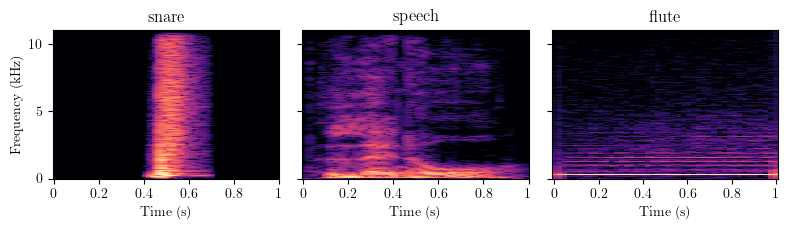

In [8]:
hop_lengths = [128, 128, 512]
titles = ['snare', 'speech', 'flute']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.4), sharey=True)

for x_id, x in enumerate(xs_real):
    ax = axes[x_id]
    D = librosa.amplitude_to_db(np.abs(librosa.stft(x, hop_length=hop_lengths[x_id])), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', hop_length=hop_lengths[x_id], ax=ax)
    ax.set(title=titles[x_id])
    ax.label_outer()
    ax.set_xlabel('Time (s)')
    axes[0].set_ylabel('Frequency (kHz)')
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yticks(np.arange(0, 10001, 5000), ['0', '5', '10'])


plt.tight_layout()

plt.savefig('plots/spectrograms.pdf', bbox_inches='tight')

In [ ]:
J = 256
T = [512]

Y = np.zeros((3, 1000))

for x_id, x in enumerate(xs_real):
    Y[x_id,:] = fb.random_filterbank_experiment(x, J, N_real, T)

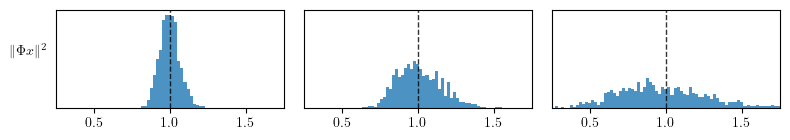

In [10]:
titles = ['snare', 'speech', 'flute']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 1.5), sharey='row')

for x_id, x in enumerate(xs_real):
    ax = axes[x_id]
    ax.hist(Y[x_id,:], range=[0.25,1.75], bins=75, density=True, alpha=0.8)
    ax.axvline(1, color = 'black', label = 'axvline - full height', alpha=0.8, linewidth=1, linestyle='--')
    ax.set_yticks([])
    ax.set_xlim(0.25, 1.75)

    axes[0].set_ylabel('$\Vert \Phi x \Vert^2$', rotation='horizontal', labelpad=16)

plt.tight_layout()

#plt.savefig('plots/energy.pdf', bbox_inches='tight')

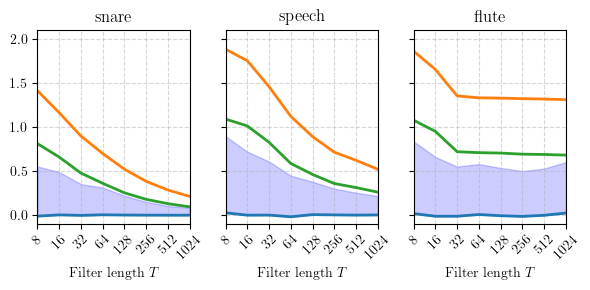

In [10]:
J = 10
p = 0.05
fig, axes = plt.subplots(1, 3, figsize=(6, 3), sharey=True)
titles = ['snare', 'speech', 'flute']
yticks = range(-2, 4)

for x_id, x in enumerate(xs_real):

    Ts = np.arange(0, len(T_vals))

    # filterbank energy stats

    Y = fb.random_filterbank_experiment(x, J, N_real, T_vals)
    Y_mean = np.mean(Y-1, axis=1)
    Y_quan = np.quantile(Y-1, 0.95, axis=1)

    Y_std = np.std(Y-1, axis = 1)
    Y_ci = (1+p) * Y_std

    Y_low = Y_mean - Y_ci
    Y_high = Y_mean + Y_ci
    
    # theoretical bounds

    cheb = fb.alpha_can(x, J, T_vals, p)

    cher = np.zeros(len(T_vals))
    for i,T in enumerate(T_vals):
        T = [T]
        out = fb.alpha_cher(x,J,T)
        cher[i] = out

    ax = axes[x_id]
    ax.plot(Y_mean, 'tab:blue', linewidth=2, label='Empirical')
    ax.fill_between(Ts, Y_mean, Y_quan, color='b', alpha=.2)

    ax.plot(cheb, 'tab:orange', linewidth=2, label='Canelli')
    ax.plot(cher, 'tab:green', linewidth=2, label='Chernoff')

    ax.set_title(titles[x_id])
    ax.set_xticks(Ts, T_vals, rotation=45);
    ax.set_xlabel('Filter length $T$')
    #if x_id == 0:
        #ax.legend(loc='upper right',fontsize = "small")

    ax.set_xlim(min(Ts), max(Ts))
    ax.set_ylim(-0.1, 2.1)
    ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('plots/energy_deviation_bounds_2.pdf', bbox_inches='tight')